In [1]:
import numpy as np
from copy import deepcopy
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers,regularizers,metrics,optimizers
import random
import pandas as pd
from scipy.linalg import sqrtm
import pickle
from typing import Any, Callable, Dict, List, Optional, Union
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import math
import scipy.stats as st
from scipy.special import comb
from collections import defaultdict
import tensorflow_probability as tfp

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
config=tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth=True
sess=tf.compat.v1.Session(config=config) 

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255
y_train_onehot=tf.keras.utils.to_categorical(y_train,num_classes=10)
y_test_onehot=tf.keras.utils.to_categorical(y_test,num_classes=10)
y_train=y_train.reshape(50000)

In [ ]:
"""
This code is the first part of the code used to generate the redundancy evaluation algorithm's distillation data. 
This part of the code mainly learns the key features in the original data by directly studying the 
similarities in the means and variances of the distillation data and the original data (or the 
features extracted by the feature extractor), thereby obtaining distillation data that is similar to 
the original data.
"""

In [4]:
initial_lr = 1e-2
epochs = 400
warmup_epochs = 10
batch = 2000

In [5]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, total_steps, warmup_steps, warmup_lr=0.0):
        super().__init__()
        self.base_lr = base_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.warmup_lr = warmup_lr
    def __call__(self, step):
        if step is None:
            step = tf.constant(0)
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        total_steps = tf.cast(self.total_steps, tf.float32)
        warmup_percent_done = step / warmup_steps
        learning_rate = tf.where(
            step < warmup_steps,
            self.warmup_lr + (self.base_lr - self.warmup_lr) * warmup_percent_done,
            self.base_lr * 0.5 * (1.0 + tf.cos(math.pi * (step - warmup_steps) / (total_steps - warmup_steps)))
        )
        return learning_rate
    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "total_steps": self.total_steps,
            "warmup_steps": self.warmup_steps,
            "warmup_lr": self.warmup_lr,
        }

In [6]:
class CustomWeightDecaySGD(tf.keras.optimizers.SGD):
    def __init__(self, weight_decay, **kwargs):
        super().__init__(**kwargs)
        self.weight_decay = weight_decay

    def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
        new_grads_and_vars = []
        for (grad, var) in grads_and_vars:
            if ('kernel' in var.name) and ('bn' not in var.name.lower()):
                grad += self.weight_decay * var
            new_grads_and_vars.append((grad, var))
        return super().apply_gradients(new_grads_and_vars, name, experimental_aggregate_gradients)
    def get_config(self):
        return {
            "weight_decay": self.weight_decay,
            **super().get_config(),
        }

In [7]:
model_R_1=keras.models.load_model("Res18_cifar10.h5",custom_objects={
        'CustomWeightDecaySGD': CustomWeightDecaySGD,
        'WarmUpCosine': WarmUpCosine
    })
model_R_2=keras.models.load_model("Res32_cifar10.h5",custom_objects={
        'CustomWeightDecaySGD': CustomWeightDecaySGD,
        'WarmUpCosine': WarmUpCosine
    })
model_V=keras.models.load_model("VGG16_cifar10.h5",custom_objects={
        'CustomWeightDecaySGD': CustomWeightDecaySGD,
        'WarmUpCosine': WarmUpCosine
    })

In [8]:
def create_model_CNN(input_shape=(32,32,3),):
    """
    This function builds a CNN extractor for extracting image features. 
    It consists of three convolutional layers - batch normalization layers 
    - ReLU layers - max pooling layers - and is used to extract feature 
    information from the data after initialization.
    """
    model_CNN=model = keras.models.Sequential()
    model_CNN.add(layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same',
                 input_shape=input_shape))
    
    model_CNN.add(layers.BatchNormalization())
    model_CNN.add(layers.Activation('relu'))
    model_CNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_CNN.add(layers.Conv2D(8, (3, 3), padding='same'))
    model_CNN.add(layers.BatchNormalization())
    model_CNN.add(layers.Activation('relu'))
    model_CNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_CNN.add(layers.Conv2D(8, (3, 3), padding='same'))
    model_CNN.add(layers.BatchNormalization())
    model_CNN.add(layers.Activation('relu'))
    model_CNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_CNN.add(layers.Flatten())
    model_CNN.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), metrics=['accuracy']) 
    return model_CNN

In [9]:
def create_model(i):
    return create_model_CNN()

In [10]:
s=200
K=10
N=10

In [11]:
x_dist=tf.random.normal((s*K,32,32,3),0.5,1)

In [12]:
x_dist=tf.clip_by_value(x_dist, 0.0, 1.0)

In [13]:
y_dist=np.zeros(s*K)

In [14]:
for i in range(K):
    y_dist[i*s:(i+i)*s]=i

In [15]:
indices=np.arange(s*K)
np.random.shuffle(indices)
x_dist=tf.gather(x_dist,indices)
y_dist=tf.gather(y_dist,indices)

In [16]:
with open('data_dist_10.pkl', 'wb') as f:
    pickle.dump([0,x_train,y_train,x_dist,y_dist],f)

In [11]:
def feature_train(x,models,L,N=N,b=128):
    f=np.zeros((N,batch,b))
    for i in range(10):
        model=models[i]
        layer_outputs =[layer.output for layer in model.layers] 
        activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
        layer=activation_model.predict(x)
        f[i]=layer[-1]
    return f

In [12]:
def feature_dist(x,models,N=N,b=128):
    x=tf.reshape(x,[s*K,32,32,3])
    for i in range(N):
        model=models[i]
        if i==0:
            f=model(x)
            f=tf.reshape(f,[1,s*K,b])
        else:
            f_i=tf.reshape(model(x),[1,s*K,b])
            f=tf.concat([f,f_i], axis=0)
    return tf.cast(f,dtype=tf.float32)

In [13]:
def tf_conv(x):
    cov_xx = tfp.stats.covariance(x)
    return cov_xx

In [14]:
def tf_mean(x):
    return tf.reduce_mean(x, axis=0)

In [15]:
def loss_dm(x_t,x_s):
    dm_l=tf.reduce_mean(x_t, axis=0)-tf.reduce_mean(x_s, axis=0)
    return tf.norm(dm_l)

In [16]:
def loss_DM(x_t,x_s,y_t,y_s,K=K):
    DM_l=tf.TensorArray(dtype=tf.float32, size=K)
    for i in range(K):
        x_ti=tf.boolean_mask(x_t,tf.equal(y_t,i))
        x_si=tf.boolean_mask(x_s,tf.equal(y_s,i))
        DDD=tf_mean(x_ti)-tf_mean(x_si)
        DM_l=DM_l.write(i, tf.norm(DDD))
        del x_ti,x_si
    return tf.reduce_mean(DM_l.stack())

In [17]:
def loss_cov(x_t,x_s,y_t,y_s,K=K):
    cov_l=tf.TensorArray(dtype=tf.float32, size=K)
    for i in range(K):
        x_ti=tf.boolean_mask(x_t,tf.equal(y_t,i))
        x_si=tf.boolean_mask(x_s,tf.equal(y_s,i))
        CCC=tf.norm(tf_conv(x_ti)-tf_conv(x_si))
        cov_l=cov_l.write(i, tf.norm(CCC))
        del x_ti,x_si
    return tf.reduce_mean(cov_l.stack())

In [ ]:
"""The 'loss' function calculates the difference in mean and variance 
between the original data and the distillation data. While the 'loss_lam' 
function calculates the difference in mean and variance between the 
original data and the distillation data, which are extracted features 
by multiple CNN feature extractors."""

In [18]:
def loss(x_t,x_s,y_t,y_s,lam_1):
    dm_l=loss_DM(x_t,x_s,y_t,y_s)
    cov_l=loss_cov(x_t,x_s,y_t,y_s)
    return dm_l+lam_1*cov_l

In [19]:
def loss_lam(x_t,x_s,y_t,y_s,lam_1):
    dm_l=np.zeros(N)
    cov_l=np.zeros(N)
    class_l=np.zeros(N)
    for i in range(N):
        dm_l[i]=loss_DM(x_t[i],x_s[i],y_t,y_s)
        cov_l[i]=loss_cov(x_t[i],x_s[i],y_t,y_s)
    dm_l=np.sum(dm_l)
    cov_l=np.sum(cov_l)
    return dm_l+lam_1*cov_l

In [20]:
def create_balanced_batches(data, labels, num_classes=10, samples_per_class_per_batch=200):
    """This function is used for stratified sampling, 
    extracting the original samples into batches of 
    the same size as the distillation dataset."""
    class_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        class_to_indices[label].append(idx)
    for cls in range(num_classes):
        np.random.shuffle(class_to_indices[cls])
    total_per_class = len(class_to_indices[0])
    num_batches = total_per_class // samples_per_class_per_batch
    batches = []
    for batch_idx in range(num_batches):
        batch_indices = []
        for cls in range(num_classes):
            start = batch_idx * samples_per_class_per_batch
            end = start + samples_per_class_per_batch
            batch_indices.extend(class_to_indices[cls][start:end])
        np.random.shuffle(batch_indices)
        batch_data = data[batch_indices]
        batch_labels = labels[batch_indices]
        batches.append((batch_data, batch_labels))
    return batches

In [21]:
def dist_1(I,x_s):
    """
    Data Distillation Function (Data Distillation via Feature & Statistics Matching) 
    This function directly optimizes the distilled data x_s to approximate the real 
    training data on the following two levels:
    1) Input space statistical consistency (loss):
    By constraining the statistics (such as mean and variance) of the real data and 
    the distillation data in the pixel space to be consistent,it ensures that the 
    distillation data approximates the original data at the overall distribution level.
    2) Feature space consistency (loss_lam):
    Using multiple CNN models to extract the intermediate features of the real data 
    and the distillation data, constraining the differences between the two in the 
    feature space. 
    The distillation data x_s is regarded as a trainable variable 
    and is directly updated through gradient descent, ultimately resulting in a smaller 
    but representative set of distillation samples. 
    """
    lr_schedule = WarmUpCosine(0.01*(10-I), 500*(10-I), 0)
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr)
    # =========================
    # Outer loop: Distillation cycle
    # Controls the total number of rounds/stages in the distillation process
    # =========================
    for i in range((10-I)):
        NNN=len(y_train)//batch
        t_batch=create_balanced_batches(x_train,y_train)
        for j in range(NNN):
            loss_1=0
            loss_2=0
            x_batch,y_batch=t_batch[j]
            x_batch=tf.cast(x_batch,dtype=tf.float32)
            models=[create_model(i) for i in range(10)]
            x_t=tf.reshape(x_batch,[batch,32*32*3])
            f_t=tf.convert_to_tensor(feature_train(x_batch,models,batch))
            f_t=tf.cast(f_t,dtype=tf.float32)
            # =========================
            # Inner loop: Data distillation optimization
            # Update x_s multiple times to match the statistics and features of the current batch
            # =========================
            for k in range(20):
                with tf.GradientTape() as tape:
                    tape.watch(x_s)
                    x_dist=tf.reshape(x_s,[s*K,32,32,3])
                    f_s=feature_dist(x_s,models)
                    loss_f=loss_lam(f_t,f_s,y_batch,y_dist,lam_1)
                    loss_x=loss(x_t,x_s,y_batch,y_dist,lam_1)
                    loss_=loss_f+loss_x
                grad = tape.gradient(loss_, x_s)
                optimizer.apply_gradients(zip([grad], [x_s]))
                x_s.assign(tf.clip_by_value(x_s, 0.0, 1.0))
                loss_1+=loss_x
                loss_2+=loss_f
            if (j+1)%5==0:
                print(loss_1,loss_2)
                x_dist=tf.reshape(x_s,[s*K,32,32,3])
                a1=model_R_1.evaluate(x_dist,y_dist_onehot)
                a2=model_R_2.evaluate(x_dist,y_dist_onehot)
                a3=model_V.evaluate(x_dist,y_dist_onehot)
                print(i,j)
        with open('data_dist_10.pkl', 'wb') as f:
            pickle.dump([int(i+1),x_train,y_train,x_dist,y_dist],f)
    return tf.reshape(x_s,[s*K,32,32,3])

In [22]:
with open('data_dist_10.pkl', 'rb') as f:
    [I,x_train,y_train,x_dist,y_dist]=pickle.load(f)

In [23]:
lam_1=0.1
y_dist_onehot=tf.keras.utils.to_categorical(y_dist,num_classes=10)

In [24]:
x_t=tf.reshape(x_train,[50000,32*32*3])
x_s=tf.reshape(x_dist,[s*K,32*32*3])
x_s=tf.Variable(x_s)
lam_1=0.1
y_dist_onehot=tf.keras.utils.to_categorical(y_dist,num_classes=10)

In [25]:
I

2

In [26]:
x_dist=dist_1(I,x_s)

tf.Tensor(37.074142, shape=(), dtype=float32) 18.21462980397046
63/63 [==============================] - 1s 9ms/step - loss: 3.6980 - accuracy: 0.1405
0 4
tf.Tensor(36.39868, shape=(), dtype=float32) 18.866321595665074
63/63 [==============================] - 0s 8ms/step - loss: 3.6474 - accuracy: 0.1430
0 9
tf.Tensor(37.002785, shape=(), dtype=float32) 18.958274888293822
63/63 [==============================] - 1s 8ms/step - loss: 3.5814 - accuracy: 0.1580
0 14
tf.Tensor(35.484493, shape=(), dtype=float32) 22.888142175413662
63/63 [==============================] - 0s 6ms/step - loss: 3.5032 - accuracy: 0.1770
0 19
tf.Tensor(35.66543, shape=(), dtype=float32) 18.034751021768894
63/63 [==============================] - 0s 8ms/step - loss: 3.4607 - accuracy: 0.1785
0 24
tf.Tensor(34.09624, shape=(), dtype=float32) 19.165983937773852
63/63 [==============================] - 0s 6ms/step - loss: 3.3508 - accuracy: 0.2050
1 4
tf.Tensor(39.282387, shape=(), dtype=float32) 18.019937486108393


In [27]:
a1=model_R_1.evaluate(x_dist,y_dist_onehot)
a2=model_R_2.evaluate(x_dist,y_dist_onehot)
a3=model_V.evaluate(x_dist,y_dist_onehot)

63/63 [==============================] - 0s 7ms/step - loss: 2.1248 - accuracy: 0.4965


In [28]:
with open('data_dist_10.pkl', 'wb') as f:
    pickle.dump([0,x_train,y_train,x_dist,y_dist],f)

tf.Tensor(2.0, shape=(), dtype=float64)


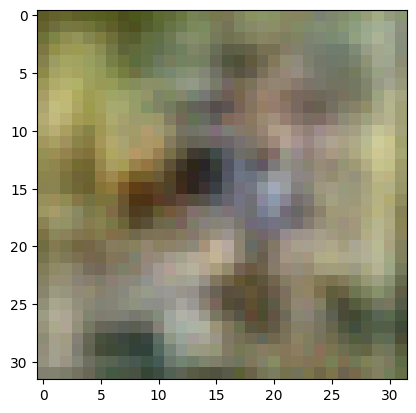

In [29]:
m=3
plt.imshow(x_dist[m])
print(y_dist[m])

In [30]:
with open('data_dist_10.pkl', 'rb') as f:
    [I,x_train,y_train,x_dist,y_dist]=pickle.load(f)